In [1]:
#from google.colab import drive
import os
#drive.mount("/content/drive/", force_remount=True)
#!pip install -r '/content/drive/MyDrive/WCD_ML_project/CV_Capstone/Deepglobe/requirements.txt'
#%cd '/content/drive/MyDrive/WCD_ML_project/CV_Capstone/Deepglobe/'

In [2]:
import sys
import sys
sys.path.append('/Users/noeliaotero/Documents/WeCloudData/Capstone_project/Deepglobe/')

In [5]:
import os, cv2
import csv
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import sys
sys.path.insert(0, os.path.abspath('../'))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import albumentations as album
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils.metrics

from PIL import Image, ImageFile
from Dataset import DeepGlobeDataset
from utils.utils import *
import segmentation_models_pytorch as smp
from utils.get_subset_data import *
from model import *
import yaml


In [9]:
script_dir = os.path.dirname(os.path.abspath(''))

# Combine the script directory with the filename to get the full path to config.yaml
config_file = os.path.join(script_dir, 'config.yaml')

In [14]:
config=load_config(config_file)

In [11]:
train_df, valid_df, test_df = get_subset_data(config['DATA_DIR'], batch_size=3, num_workers=2, validation_split=0.1)
select_class_rgb_values = get_classes(config['DATA_DIR'], config['CLASSES'])

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']
Class RGB values:  [[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]


In [12]:
ENCODER = config['ENCODER']
ENCODER_WEIGHTS = config['ENCODER_WEIGHTS']

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

train_dataset = DeepGlobeDataset( train_df,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    one_hot_encode=one_hot_encode,
    class_rgb_values=select_class_rgb_values,
    )

valid_dataset = DeepGlobeDataset( valid_df,
        augmentation=get_validation_augmentation(),
        preprocessing=get_preprocessing(preprocessing_fn),
        one_hot_encode=one_hot_encode,
        class_rgb_values=select_class_rgb_values,
    )

test_dataset = DeepGlobeDataset(test_df,
        augmentation=get_validation_augmentation(),
        preprocessing=get_preprocessing(preprocessing_fn),
        one_hot_encode=one_hot_encode,
        class_rgb_values=select_class_rgb_values,
    )

test_dataset_vis = DeepGlobeDataset(
        test_df,
        augmentation=get_validation_augmentation(),
        class_rgb_values=select_class_rgb_values,
    )

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


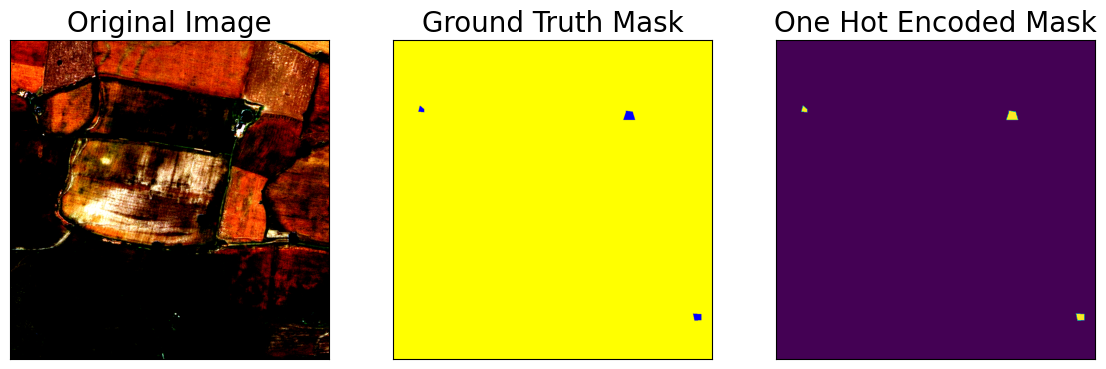

In [13]:
# checking!
random_idx = random.randint(0, len(train_dataset)-1)
image, mask = train_dataset[1]

visualize(
    original_image = np.transpose(image,(1,2,0)),
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(np.transpose(mask,(1,2,0))), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(np.transpose(mask,(1,2,0)))
)

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

def train(model, train_loader, valid_loader, num_epochs=10, learning_rate=0.0008, EPOCHS=10, plot=True):

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(DEVICE)

    # define loss function
    loss = smp.utils.losses.DiceLoss()

    # define metrics
    metrics = [
        smp.utils.metrics.IoU(threshold=0.5),
    ]

    # define optimizer
    optimizer = torch.optim.Adam([
        dict(params=model.parameters(), lr=0.00008),
    ])

    # define learning rate scheduler (not used in this NB)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=1, T_mult=2, eta_min=5e-5,
    )

    # Lists to store training statistics for plotting
    train_loss_history = []
    train_iou_history = []
    valid_loss_history = []
    valid_iou_history = []

    # Training loop
    for epoch in range(EPOCHS):
        # Training
        model.to(DEVICE)
        model.train()
        train_loss = 0.0
        train_iou = 0.0

        # Create a progress bar for the training loop
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}/{EPOCHS}')

        for batch_idx, (inputs, target_masks) in progress_bar:
            inputs = inputs.to(DEVICE)
            target_masks = target_masks.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss_value = loss(outputs, target_masks)
            loss_value.backward()
            optimizer.step()

            train_loss += loss_value.item()

            # Calculate IoU for training
            outputs_bin = (outputs > 0.5).float()
            iou_batch = (outputs_bin * target_masks).sum() / ((outputs_bin + target_masks) > 0).sum()
            train_iou += iou_batch.item()

        # Calculate average loss and IoU for training
        train_loss /= len(train_loader)
        train_iou /= len(train_loader)

        # Validation
        model.eval()
        valid_loss = 0.0
        valid_iou = 0.0

        with torch.no_grad():
            for batch_idx, (inputs, target_masks) in enumerate(valid_loader):
                inputs = inputs.to(DEVICE)
                target_masks = target_masks.to(DEVICE)

                outputs = model(inputs)
                loss_value = loss(outputs, target_masks)

                valid_loss += loss_value.item()

                # Calculate IoU for validation
                outputs_bin = (outputs > 0.5).float()
                iou_batch = (outputs_bin * target_masks).sum() / ((outputs_bin + target_masks) > 0).sum()
                valid_iou += iou_batch.item()

        # Calculate average loss and IoU for validation
        valid_loss /= len(valid_loader)
        valid_iou /= len(valid_loader)

        # Store training statistics for plotting
        train_loss_history.append(train_loss)
        train_iou_history.append(train_iou)
        valid_loss_history.append(valid_loss)
        valid_iou_history.append(valid_iou)

        save_dir = '/content/drive/MyDrive/WCD_ML_project/CV_Capstone/Deepglobe/models/' #need to adjust this
        if save_dir and not os.path.exists(save_dir):
                os.makedirs(save_dir)
        torch.save(model.state_dict(), os.path.join(save_dir, "final_model.pth"))

    if plot:
      # Plot training statistics
      plt.figure(figsize=(12, 4))
      plt.subplot(1, 2, 1)
      plt.plot(range(1, epoch+2), train_loss_history, label='Train Loss')
      plt.plot(range(1, epoch+2), valid_loss_history, label='Valid Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()

      plt.subplot(1, 2, 2)
      plt.plot(range(1, epoch+2), train_iou_history, label='Train IoU')
      plt.plot(range(1, epoch+2), valid_iou_history, label='Valid IoU')
      plt.xlabel('Epoch')
      plt.ylabel('IoU')
      plt.legend()

      plt.show()


In [15]:
# Train
model = build_model(config)

In [15]:
#train(model, train_loader, valid_loader, num_epochs=10, learning_rate=0.001)

In [ ]:
from tqdm import tqdm

EPOCHS = 10

# Lists to store training statistics for plotting
train_loss_history = []
train_iou_history = []
valid_loss_history = []
valid_iou_history = []

# Training loop
for epoch in range(EPOCHS):
    # Training
    model.to(DEVICE)
    model.train()
    train_loss = 0.0
    train_iou = 0.0

    # Create a progress bar for the training loop
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}/{EPOCHS}')

    for batch_idx, (inputs, target_masks) in progress_bar:
        inputs = inputs.to(DEVICE)
        target_masks = target_masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss_value = loss(outputs, target_masks)
        loss_value.backward()
        optimizer.step()

        train_loss += loss_value.item()

        # Calculate IoU for training
        outputs_bin = (outputs > 0.5).float()
        iou_batch = (outputs_bin * target_masks).sum() / ((outputs_bin + target_masks) > 0).sum()
        train_iou += iou_batch.item()

    # Calculate average loss and IoU for training
    train_loss /= len(train_loader)
    train_iou /= len(train_loader)

    # Validation
    model.eval()
    valid_loss = 0.0
    valid_iou = 0.0

    with torch.no_grad():
        for batch_idx, (inputs, target_masks) in enumerate(valid_loader):
            inputs = inputs.to(DEVICE)
            target_masks = target_masks.to(DEVICE)

            outputs = model(inputs)
            loss_value = loss(outputs, target_masks)

            valid_loss += loss_value.item()

            # Calculate IoU for validation
            outputs_bin = (outputs > 0.5).float()
            iou_batch = (outputs_bin * target_masks).sum() / ((outputs_bin + target_masks) > 0).sum()
            valid_iou += iou_batch.item()

    # Calculate average loss and IoU for validation
    valid_loss /= len(valid_loader)
    valid_iou /= len(valid_loader)

    # Store training statistics for plotting
    train_loss_history.append(train_loss)
    train_iou_history.append(train_iou)
    valid_loss_history.append(valid_loss)
    valid_iou_history.append(valid_iou)

# End of training loop


Epoch 10/10: 100%|██████████| 281/281 [19:39<00:00,  4.20s/it]


In [ ]:
save_dir = '/content/drive/MyDrive/WCD_ML_project/CV_Capstone/Deepglobe/models/'
if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir)
torch.save(model.state_dict(), os.path.join(save_dir, "final_model.pth"))

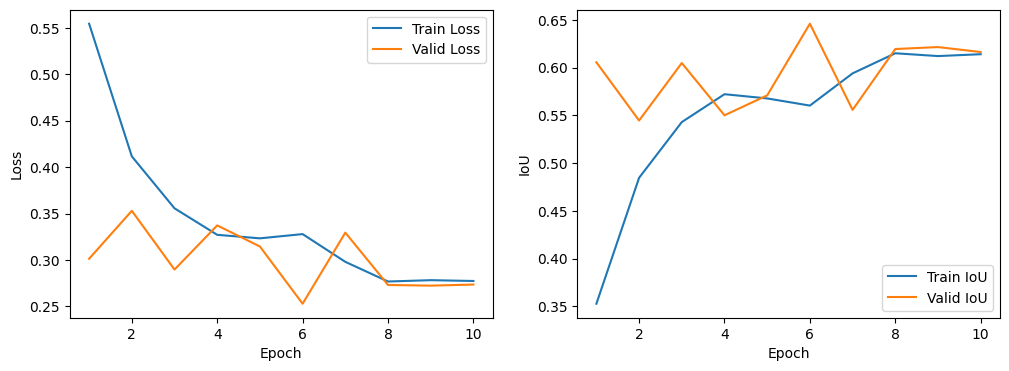

In [ ]:
# Plot training and validation statistics
# Plot training statistics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, epoch+2), train_loss_history, label='Train Loss')
plt.plot(range(1, epoch+2), valid_loss_history, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epoch+2), train_iou_history, label='Train IoU')
plt.plot(range(1, epoch+2), valid_iou_history, label='Valid IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.show()




### Inference part

In [ ]:

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('/content/drive/MyDrive/WCD_ML_project/CV_Capstone/Deepglobe/models/final_model.pth'):
    model_state_dict = torch.load('/content/drive/MyDrive/WCD_ML_project/CV_Capstone/Deepglobe//models/final_model.pth', map_location=DEVICE)
    print('Loaded pre-trained DeepLabV3+ model!')

Loaded pre-trained DeepLabV3+ model!


In [ ]:
# Load the state dict into the model
model.load_state_dict(model_state_dict)
model.eval()
model.to(DEVICE)

In [ ]:
def visualize_predictions(image_vis, gt_mask, pred_mask, class_names, class_rgb_values):

        pred_mask = np.transpose(pred_mask,(1,2,0))
        # Get prediction channel corresponding to foreground
        pred_urban_land_heatmap = pred_mask[:,:,select_classes.index('urban_land')]
        pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)

        # Convert gt_mask from `CHW` format to `HWC` format
        gt_mask = np.transpose(gt_mask,(1,2,0))
        gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values)

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

        ax1.imshow(image_vis)
        ax1.set_title('Image')
        ax2.imshow(gt_mask)
        ax2.set_title('Ground Truth')
        ax3.imshow(pred_mask)
        ax3.set_title('Predicted mask')


        # Create legend
        legend_patches = [mpatches.Patch(color=np.array([c]) / 255, label=class_name)
                          for class_name, c in zip(class_names, class_rgb_values)]

        ax3.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

        plt.show()

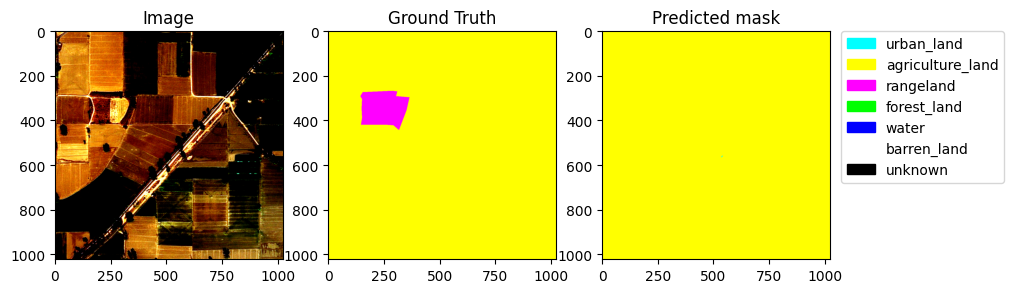

In [ ]:
def predict_and_visualize(model, data_test, class_names, class_rgb_values, device=DEVICE):
    model.to(device)
    model.eval()

    images, gt_masks = next(iter(data_test))
   #image_vis = test_dataset_vis[idx][0].astype('uint8')
    x_tensor = torch.from_numpy(images).to(device).unsqueeze(0)

    with torch.no_grad():

        # Predict test image
        pred_mask = model(x_tensor)
        pred_mask = pred_mask.detach().squeeze().cpu().numpy()

    visualize_predictions( np.transpose(images,(1,2,0)), gt_masks, pred_mask, class_names, class_rgb_values)

# Example usage:
predict_and_visualize(model, test_dataset, class_names, select_class_rgb_values)

In [ ]:
precision_arr = []
recall_arr = []
f1_arr = []
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    print(pred_mask.shape)
    true_pred = np.argmax(pred_mask,axis=0)
    tp = (gt_mask * true_pred).sum()
    tn = ((1 - gt_mask) * (1 - true_pred)).sum()
    fp = ((1 - gt_mask) * true_pred).sum()
    fn = (gt_mask * (1 - true_pred)).sum()

    epsilon = 1e-7

    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)

    f1 = 2* (precision*recall) / (precision + recall + epsilon)

    precision_arr.append(precision)
    recall_arr.append(recall)
    f1_arr.append(f1)

    epsilon = 1e-7

    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)

    f1 = 2* (precision*recall) / (precision + recall + epsilon)

    print(f'Precision: {precision}, Recall: {recall}, F1: {f1}')

    visualize_predictions(image_vis, gt_mask, pred_mask, class_names, class_rgb_values)


    # Convert pred_mask from `CHW` format to `HWC` format
    #pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to foreground
    # pred_urban_land_heatmap = pred_mask[:,:,select_classes.index('urban_land')]
    # pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
    #pred_mask = reverse_one_hot(pred_mask)
    # Convert gt_mask from `CHW` format to `HWC` format
    #gt_mask = np.transpose(gt_mask,(1,2,0))
    #gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values)


    #fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 5))

    #ax1.imshow(image_vis)
    #ax1.set_title('Image')
    #ax2.imshow(gt_mask)
    #ax2.set_title('Ground Truth')
    #ax3.imshow(pred_mask)
    #ax3.set_title('Predicted mask')
    #plt.show()




Output hidden; open in https://colab.research.google.com to view.

In [16]:


def preprocess_image(image_path):
    # Add any necessary preprocessing steps for your input image
    # For example, resizing, normalization, etc.
    img = Image.open(image_path)
    # Perform any necessary transformations on 'img'
    # ...

    # Convert the image to a PyTorch tensor
    img = transforms.ToTensor()(img)

    # Add batch dimension
    img = img.unsqueeze(0)
    return img

def inference_single_image(model, image_path):

    
    model.eval()  # Set the model to evaluation mode

    # Preprocess the input image
    input_image = preprocess_image(image_path)

    # Move the input to the device used for training (e.g., GPU)
    input_image = input_image.to(DEVICE)

    # Perform inference
    with torch.no_grad():
        output = model(input_image)

    # Process the output as needed
    # (e.g., applying softmax for classification)
    # processed_output = ...

    return output.cpu().numpy()

In [20]:
model_dir='../Deepglobe/models/final_model.pth'
images_dir = '../Deepglobe/data/test/'

In [23]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


In [39]:
model = build_model('config.yaml')
state_dict = torch.load(model_dir, map_location=torch.device(DEVICE))
model.load_state_dict(state_dict)


<All keys matched successfully>

In [40]:
examples = os.listdir(images_dir)
image_files = [os.path.join(images_dir, filename) for filename in examples if filename.endswith('.jpg')]
print(image_files)
   

['../Deepglobe/data/test/209073_sat.jpg', '../Deepglobe/data/test/157550_sat.jpg', '../Deepglobe/data/test/85922_sat.jpg', '../Deepglobe/data/test/186618_sat.jpg', '../Deepglobe/data/test/537287_sat.jpg', '../Deepglobe/data/test/26961_sat.jpg', '../Deepglobe/data/test/114542_sat.jpg', '../Deepglobe/data/test/115800_sat.jpg', '../Deepglobe/data/test/289091_sat.jpg', '../Deepglobe/data/test/531070_sat.jpg', '../Deepglobe/data/test/391840_sat.jpg', '../Deepglobe/data/test/337870_sat.jpg', '../Deepglobe/data/test/477322_sat.jpg', '../Deepglobe/data/test/6390_sat.jpg', '../Deepglobe/data/test/688913_sat.jpg', '../Deepglobe/data/test/4102_sat.jpg', '../Deepglobe/data/test/874750_sat.jpg', '../Deepglobe/data/test/1499_sat.jpg', '../Deepglobe/data/test/666005_sat.jpg', '../Deepglobe/data/test/565912_sat.jpg', '../Deepglobe/data/test/232937_sat.jpg', '../Deepglobe/data/test/988205_sat.jpg', '../Deepglobe/data/test/818398_sat.jpg', '../Deepglobe/data/test/999380_sat.jpg', '../Deepglobe/data/test

In [41]:
result = inference_single_image(model, image_files[0])

cpu


In [55]:
def visualize_predictions(image_path,  pred_mask, gt_mask=None):
  

        image_vis = preprocess_image(image_path)
        pred_mask = np.transpose(pred_mask,(1,2,0))
        # Get prediction channel corresponding to foreground
        select_class_indices = [config['CLASSES'].index(cls.lower()) for cls in config['CLASSES']]
        select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]
        pred_urban_land_heatmap = pred_mask[:,:,config['CLASSES'].index('urban_land')]
        pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)

        # Convert gt_mask from `CHW` format to `HWC` format
        if gt_mask is not None:
                gt_mask = np.transpose(gt_mask,(1,2,0))
                gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values)

                fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

                ax1.imshow(image_vis)
                ax1.set_title('Image')
                ax2.imshow(gt_mask)
                ax2.set_title('Ground Truth')
                ax3.imshow(pred_mask)
                ax3.set_title('Predicted mask')

        else:
                fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
                overlay = cv2.addWeighted(image_vis, 0.7, pred_mask, 0.3, 0)
        

                ax1.imshow(image_vis)
                ax1.set_title('Image')
                ax2.imshow(pred_mask)
                ax2.set_title('Predicted mask')
                ax3.imshow(overlay)
                ax3.set_title('Overaly')


        # Create legend
        #legend_patches = [mpatches.Patch(color=np.array([c]) / 255, label=class_name)
        #                  for class_name, c in zip(class_names, class_rgb_values)]

        #ax3.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

        plt.show()

In [62]:
pred_mask = np.transpose(result[0],(1,2,0))
pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)

In [64]:
image_vis = preprocess_image(image_files[0])

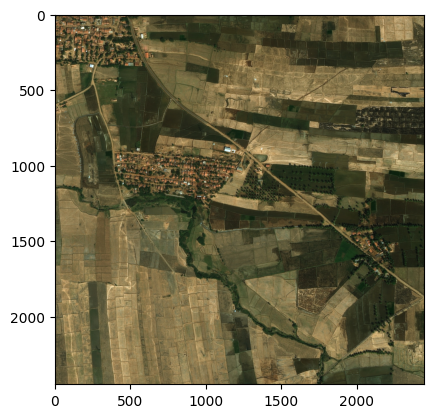

In [66]:
plt.imshow(np.transpose(image_vis[0],(1,2,0)))

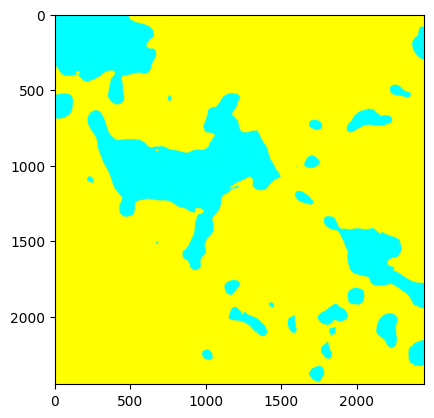

In [63]:
plt.imshow(pred_mask)